# Binary Classification
This notebook will approach the popularity prediction task as a binary classification problem. The videos will either be classified as viral or non-viral

In [1]:
%cd ..

C:\Users\georg\Documents\msc-project


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import neighbors, svm, linear_model,dummy,ensemble
from sklearn.metrics import make_scorer, precision_score, recall_score,f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from src.evaluation import compare_models
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline

In [3]:
df = pd.read_csv("data/interim/tracks_clean.csv")

The threshold chosen for the viral videos will be 1e+06, as most videos seem to be below this threshold.

<AxesSubplot:ylabel='View count'>

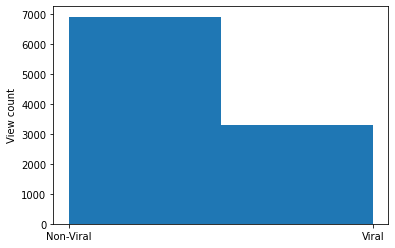

In [4]:
viral_threshold = 1e+06
features = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature',
    'duration_ms',
    'popularity'
]

def get_data_for_threshold(threshold):
    views = df['views']
    data = df.loc[:,features]
    targets = views.apply(np.digitize,bins=[0,threshold,views.max() +1])

    return data, targets

data, targets = get_data_for_threshold(viral_threshold)
plt.xticks([1,2],["Non-Viral","Viral"])
plt.ylabel("View count")
targets.hist(bins=2, grid=False)

## Model Comparison
Similar to the multiclass classification task, multiple models are evaluated and compared

In [5]:
models = [
    ("Baseline",dummy.DummyClassifier(strategy='stratified')),
    ("5-KNN",neighbors.KNeighborsClassifier(n_neighbors=5)),
    ("10-KNN",neighbors.KNeighborsClassifier(n_neighbors=10)),
    ("SVM Linear", svm.SVC(kernel='linear')),
    ("SVM RBF", svm.SVC(kernel='rbf')),
    ("Random Forest",ensemble.RandomForestClassifier()),
    ("Logistic Regression",linear_model.LogisticRegression())
]

oversampled_models = []
for name, model in models:
    combined = make_pipeline(
        ADASYN(),
        model
    )
    oversampled_models.append((name,combined))
    
metrics = {
    'precision': make_scorer(precision_score,average='macro',zero_division=0),
    'recall': make_scorer(recall_score,average='macro'),
    'accuracy': 'accuracy'
}
compare_models(oversampled_models, metrics, data, targets)

Evaluating Baseline
Evaluating 5-KNN
Evaluating 10-KNN
Evaluating SVM Linear
Evaluating SVM RBF
Evaluating Random Forest
Evaluating Logistic Regression


,model,fit_time,score_time,test_precision,test_recall,test_accuracy
0,Baseline,0.756598,0.003868,0.493557,0.492629,0.494170
1,5-KNN,0.774935,0.527563,0.526735,0.530583,0.523463
2,10-KNN,0.842686,0.593828,0.535149,0.539560,0.557460
3,SVM Linear,7.036952,0.435283,0.577972,0.586399,0.544527
4,SVM RBF,6.155957,1.906710,0.573043,0.583430,0.579308
5,Random Forest,3.249897,0.054067,0.554162,0.551518,0.618203
6,Logistic Regression,0.726333,0.004365,0.580479,0.591888,0.576074


Random forest appears to outperform the rest of the models in terms of accuracy

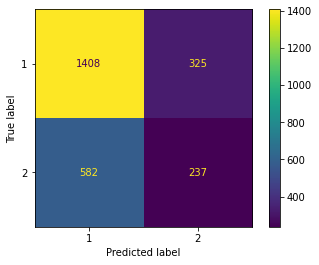

In [7]:
X_train, X_test, y_train,y_test = train_test_split(data, targets, random_state=1)
X_train, y_train = ADASYN().fit_resample(X_train,y_train)
model = ensemble.RandomForestClassifier()
model.fit(X_train,y_train)
predicted = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test,predicted)